# Topic Modelling of Song Lyrics

Project by: Ludovica Schaerf, Antònio Mendes, Jaël Kortekaas

This notebook is structured as follows:
>
>- [Introduction](#Introduction)
>
>
>- [Data and Modules Imports](#Imports-of-dataset-and-modules)
>
>
>- [Data Pre-processing Pipeline](#Preprocessing-pipeline)
>
>
>- [Modelling](#Modelling)
>
>
>- [Common topics in all songs by all artists](#Common-topics-in-all-songs-by-all-artists)
>
>
>- [Hyperparameters Tuning](#Hyperparameters-tuning)
>
>
>- [Topic distribution among documents and most representative document per topic](#Topic-distribution-among-documents-and-most-representative-document-per-topic)
>
>
>- [Evaluation](#Evaluation)
>
>
>- [Visualization](#Visualization)
>
>
>- [Exploring Different Cardinalities](#Exploring-different-cardinalities)

## Introduction

This file contains the complete pipeline to our project. As a first step we are importing the data
that we retrieved from https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics and selecting only the rows regrding the 5 artists/groups we are analyzing: David Bowie, Black Sabbath, Bruce Springsteen, Elliot Smith, Deep Purple. 

Secondly we are pre-processing the lyrics following a 'standard' pipeline (filtering, normalization and lemmatization) and adding the most common bigrams to our bag of words representation. 

From this BOW representation of all the songs from all the artists in our corpus we made the first Latent Dirichlet model (LDA). The latter is then tuned, evaluated and visualized. 

As a last effort, we tried modelling also different cardinalities: 
- the most common topics of each artist,
- the most common topics in each year,
- the most common topics of each artist each year. 

--> to update when new stuff is added

## Import of dataset and modules
This first section contains a straighforward import of our dataset and the filtering of the rows of interest

In [1]:
#modules
from pathlib import Path
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.collocations import *
from nltk.collocations import BigramAssocMeasures
import nltk
import re
import string
import gensim
import spacy
import itertools

from gensim import corpora, models
from nltk.corpus import wordnet as wn
from operator import itemgetter
import itertools

import matplotlib.pyplot as plt

plot_dir = Path("./figures")
data_dir = Path("./data")

import sklearn
from sklearn import metrics, manifold
import scipy
from scipy import cluster
import matplotlib as mpl 
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

In [57]:
#dataset
songs = []

with open('./data/lyrics.csv', 'r', encoding="utf-8") as infile:
    songs = pd.read_csv(infile)
    
print(songs.columns)

FileNotFoundError: [Errno 2] No such file or directory: './data/lyrics.csv'

In [ ]:
#filtering of the rows pertaining to the artists of interest
artists = ['bruce-springsteen', 'elliot-smith', 'black-sabbath', 'deep-purple', 'david-bowie']

david_bowie = songs[songs[u'artist'] == 'david-bowie']
black_sabbath = songs[songs[u'artist'] == 'black-sabbath']
bruce_springsteen = songs[songs[u'artist'] == 'bruce-springsteen']
elliot_smith = songs[songs[u'artist'] == 'elliot-smith']
deep_purple = songs[songs[u'artist'] == 'deep-purple']

lyrics = pd.concat([david_bowie, black_sabbath, bruce_springsteen, elliot_smith, deep_purple], axis=0)
lyrics = lyrics.dropna()
lyrics

,index,song,year,artist,genre,lyrics
116793,116793,if-i-m-dreaming-my-life,2009,david-bowie,Rock,VERSE (there)\nWas she never there/here?\nWas ...
116794,116794,seven,2009,david-bowie,Rock,I forgot what my father said\nI forgot what he...
116795,116795,i-can-t-read,2009,david-bowie,Rock,I can't read and I can't write down\nI don't k...
116796,116796,thursday-s-child,2009,david-bowie,Rock,All of my life I've tried so hard\nDoing my be...
116797,116797,survive,2009,david-bowie,Rock,"Oh, my\nNaked eyes\nI should have kept you\nI ..."
...,...,...,...,...,...,...
67509,67509,child-in-time,1972,deep-purple,Rock,Sweet child in time\nYou'll see the line\nThe ...
67510,67510,deep-purple-overture,2015,deep-purple,Rock,"Good golly, said little miss molly\nWhen she w..."
67517,67517,paint-it-black,2015,deep-purple,Rock,"I see a red door and I want it painted black,\..."
67523,67523,anyone-s-daughter,2014,deep-purple,Rock,"Well, I stood under your bedroom window, throw..."


--> Here add a summary statistics of our data

## Preprocessing pipeline


The preprocessing pipeline we decided to implement includes the following steps:
- filtering out stopwords, puntuation, sounds typical from songs
- normalizing to case insensitivity
- lemmatizing
- adding the most common bigrams

In [ ]:
#stopwords to filter out
stop_words = stopwords.words('english')
stop_words.extend(['oh', 'yeah', 'hey', 'like', 'doo', 'oo', 'uh', 'la', 'verse', 'chorus', 'bridge', 'x2', "'m", 'da', 'ooh', 'aaaahh', 'ooo', 'duh', 'whop', 'u', 'ah', 'na', 'whoa', 'ai', "n't", 'wa', 'gon', "'ll", 'gon', "'d", "'re", "'ve", "'em", "'", 'ca', 'ha', 'wo', 'wir', 'wan', 'doe', 'well', 'sha', 'ya', 'ta', "'cause", "`", "'s"]) # filter out common meaningless words/sounds and words describing song structure

In [5]:
#rest of the pre-processing
wnl = WordNetLemmatizer()
bigram_measures = BigramAssocMeasures()

def convertTuple(tup): 
    str =  '_'.join(tup) 
    return str
  
def simple_preprocess(lyrics, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    lyricslist = [re.sub('\-', '', str(lyric)) for lyric in lyrics['lyrics'].tolist()] # take out all hyphens that often connect meaningless words/sounds to these stopwords can be filtered out later
    lyricslist = [re.sub('[\.\,\?,\!,\(,\),\:,\",\[,\]]', '', str(lyric)) for lyric in lyricslist] # take out all punctuation
    lyricslist = [word_tokenize(lyric.lower()) for lyric in lyricslist]
    finder = []
    for i,lyric in enumerate(lyricslist):
        for j,token in enumerate(lyric):
            lyricslist[i][j] = wnl.lemmatize(str(token))
        lyricslist[i] = [word for word in lyric if word not in stop_words]
        finder.append(BigramCollocationFinder.from_words(lyric))
        finder[i] = finder[i].nbest(bigram_measures.pmi, 20)
        finder[i] = [convertTuple(x) for x in finder[i]] #need to append the two words back together
        lyricslist[i] = lyricslist[i] + finder[i]
    lyrics['bag_of_words'] = lyricslist


simple_preprocess(lyrics)
example = lyrics['bag_of_words'][116793]
example

['never',
 'there/here',
 'ever',
 'air',
 'breathed',
 'wrong',
 'time',
 'ohoh',
 'ohoh',
 'flower',
 'gallery',
 'hymn',
 'night',
 'singing',
 'come',
 'wrong',
 'time',
 'wrong',
 'day',
 'light',
 'fading',
 'dreaming',
 'life',
 'second',
 'time',
 'one',
 'living',
 'chance',
 'mother',
 'sigh',
 'father',
 'step',
 'aside',
 'wrong',
 'time',
 'ohoh',
 'ever',
 'ever',
 'dreaming',
 'life',
 'dreaming',
 'life',
 'away',
 'dreaming',
 'life',
 'dreaming',
 'dreaming',
 'dreaming',
 'dreaming',
 'life',
 'dreaming',
 'life',
 'away',
 'ohoh',
 'repeat',
 'dreaming',
 'life',
 'dreaming',
 'dreaming',
 'life',
 'away',
 'ohoh',
 'are_fading',
 'come_to',
 'fading_now',
 'father_step',
 'flower_so',
 'gallery_with',
 'hymn_of',
 'it_air',
 'just_one',
 'light_are',
 'living_chance',
 'mother_sigh',
 'never_there/here',
 'night_singing',
 'of_night',
 'one_living',
 'singing_come',
 'so_from',
 'step_aside',
 'to_me']

# Modelling
Now that we have our bag of words representation, we can finally start modelling, using LDA

## Common topics in all songs by all artists
This first part is an attempt to identify some common topics, in order to have a general understanding of topics that often appear in lyrics, and visualize the distribution of those among our documents (the individual songs). 

NB: A considerable amount of the code in this section is taken from https://github.com/Giovanni1085/AUC_TMCI_2019/blob/master/notebooks/13_Clustering_TopicModelling.ipynb

In [6]:
#creation of the dictionary that Gensims LDA function requires
list_BOWlyrics = []
for lyric in lyrics['bag_of_words']:
    list_BOWlyrics += [lyric]

lyrics_dictionary = corpora.Dictionary(list_BOWlyrics)
print('Number of unique tokens:', len(lyrics_dictionary))

Number of unique tokens: 31159


In [7]:
print(dict(itertools.islice(lyrics_dictionary.token2id.items(), 12)))
print("word with id 8:", lyrics_dictionary[8])
print("frequency of token 8:", lyrics_dictionary.dfs[8])

{'air': 0, 'are_fading': 1, 'aside': 2, 'away': 3, 'breathed': 4, 'chance': 5, 'come': 6, 'come_to': 7, 'day': 8, 'dreaming': 9, 'ever': 10, 'fading': 11}
word with id 8: day
frequency of token 8: 415


In [8]:
# Filter out words that occur in less than 2 documents, or more than 30% of the documents.
lyrics_dictionary.filter_extremes(no_below=2, no_above=0.3)
print('Number of unique tokens:', len(lyrics_dictionary))

Number of unique tokens: 10555


In [10]:
# Bag-of-words representation of the documents
lyrics_bow_corpus = [lyrics_dictionary.doc2bow(d) for d in list_BOWlyrics]

# the BOW representation of the first document
print(lyrics_bow_corpus[1][:50])

[(0, 1), (1, 1), (2, 3), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 12), (9, 3), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 8), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 4)]


In [11]:
# which words (and how often) appear in the first document?
for i, freq in sorted(lyrics_bow_corpus[1], key=itemgetter(1), reverse=True)[:15]:
    print(lyrics_dictionary[i], "-->", freq)
print("...")

dreaming --> 12
life --> 8
wrong --> 4
away --> 3
ever --> 3
air --> 1
aside --> 1
breathed --> 1
chance --> 1
come --> 1
come_to --> 1
day --> 1
fading --> 1
father --> 1
flower --> 1
...


In [12]:
lyrics_ldamodel = models.ldamodel.LdaModel(lyrics_bow_corpus, num_topics=5, id2word = lyrics_dictionary, passes=25)

In [13]:
# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
lyrics_ldamodel.show_topics(formatted=False, num_words=15)

[(0,
  [('white', 0.011228379),
   ('tonight', 0.011147763),
   ('hand', 0.010480771),
   ('light', 0.010013545),
   ('raise', 0.009366837),
   ('baby', 0.008997578),
   ('somebody', 0.007875989),
   ('give', 0.0067050187),
   ('sound', 0.0065330947),
   ('feel', 0.00611236),
   ('want', 0.005934886),
   ('get', 0.0059042387),
   ('ground', 0.005783493),
   ('may', 0.0056650816),
   ('late', 0.005623038)]),
 (1,
  [('come', 0.010229068),
   ('baby', 0.009884528),
   ('back', 0.009793378),
   ('day', 0.009564779),
   ('shot', 0.008547378),
   ('dream', 0.008188437),
   ('gone', 0.007782513),
   ('home', 0.006324352),
   ('secret', 0.006200147),
   ('life', 0.006073987),
   ('away', 0.0060310285),
   ('get', 0.005385442),
   ('town', 0.005307549),
   ('said', 0.0049547427),
   ('eye', 0.0049480586)]),
 (2,
  [('girl', 0.014006153),
   ('never', 0.01168349),
   ('want', 0.011403726),
   ('let', 0.011039673),
   ('little', 0.010936005),
   ('get', 0.0102291815),
   ('heart', 0.009326884),


## Hyperparameters tuning 
Given that the topics we obtained above do not have any apparent sense, we hope to achieve a better model by tuning the following parameters:
- α: the number of topics
- β: the number of words per topic

This is implemented following the blog post https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0.
The idea is to maximize the coherence of the topics. 
The tuning is done via a grid search on all combinations of the two parameters.

The algorithm is the following:
- Choose αm from [0.05,0.1,0.5,1,5,10]
- Choose βm from [0.05,0.1,0.5,1,5,10]
- Run topic modeling on training data, with (αm,βm) pair
- Find model perplexity on hold-out test data
- Choose the value of αm and βm with the minimum perplexity

--> not precisely so needs fixing

In [22]:
lda_model = gensim.models.LdaMulticore(corpus=lyrics_bow_corpus,
                                       id2word=lyrics_dictionary,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)


In [17]:
#Evaluation
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=list_BOWlyrics, dictionary=lyrics_dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.34728851319829596


In [18]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=lyrics_bow_corpus,
                                           id2word=lyrics_dictionary,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=list_BOWlyrics, dictionary=lyrics_dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [20]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(lyrics_bow_corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(lyrics_bow_corpus, num_of_docs*0.75), 
               lyrics_bow_corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=lyrics_dictionary, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

100%|██████████████████████████████████████████████████████████████████████████████| 540/540 [2:48:02<00:00, 18.67s/it]


In [31]:
print(model_results)
import csv
csv_columns = ['Validation_Set','Topics','Alpha', 'Beta', 'Coherence']
dict_data = [model_results]
csv_file = "./TuningParameters.csv"
try:
    with open(csv_file, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
        writer.writeheader()
        for data in dict_data:
            writer.writerow(data)
except IOError:
    print("I/O error")

{'Validation_Set': ['75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', '75% Corpus', 

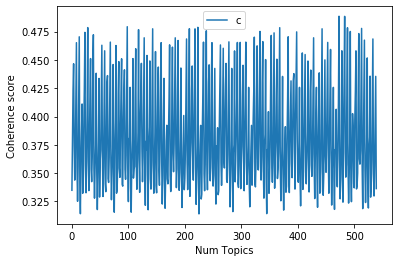

In [27]:
# Show graph
limit=40; start=2; step=6;
x = range(len(model_results['Coherence']))
plt.plot(x, model_results['Coherence'])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [29]:
# Print the coherence scores
for m, cv in zip(x,  model_results['Coherence']):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 0  has Coherence Value of 0.3348
Num Topics = 1  has Coherence Value of 0.3805
Num Topics = 2  has Coherence Value of 0.4235
Num Topics = 3  has Coherence Value of 0.4466
Num Topics = 4  has Coherence Value of 0.3738
Num Topics = 5  has Coherence Value of 0.3438
Num Topics = 6  has Coherence Value of 0.3637
Num Topics = 7  has Coherence Value of 0.4196
Num Topics = 8  has Coherence Value of 0.4653
Num Topics = 9  has Coherence Value of 0.3553
Num Topics = 10  has Coherence Value of 0.3251
Num Topics = 11  has Coherence Value of 0.3561
Num Topics = 12  has Coherence Value of 0.4097
Num Topics = 13  has Coherence Value of 0.4704
Num Topics = 14  has Coherence Value of 0.3428
Num Topics = 15  has Coherence Value of 0.3141
Num Topics = 16  has Coherence Value of 0.3613
Num Topics = 17  has Coherence Value of 0.387
Num Topics = 18  has Coherence Value of 0.4111
Num Topics = 19  has Coherence Value of 0.3322
Num Topics = 20  has Coherence Value of 0.3344
Num Topics = 21  has Coh

## Topic distribution among documents and most representative document per topic
In this section we are identifying which documents best represent each topic.
This is necessary for our analysis as we are interested in which songs can be classified as which topic

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

## Evaluation
In this section we provide an evaluation of the model using 
- topic coherence with a number of available coherence measures
- model perplexity
- rough comparison to manually annotated lyrics

Code in this section is an adaptation of the code in https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

--> still to do

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

## Visualization
In this section we adopt a number of methods to visualize the results. 
--> write which ones

In [ ]:
#Method 1
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

# Exploring Different Cardinalities
This section contains 3 new models on different levels of analysis. These are:
- the most common topics of each artist,
- the most common topics in each year,
- the most common topics of each artist each year. 

The purpose of this additional models is to provide some new insights and topics that are specific to that level of analysis.
For instance, if a topic only appears in the last model, then we can conclude that it is rather specific to one single album.

### Common topics in all songs per artist
Now we are interested in identifying what are the common topics of each artists

In [44]:
list_BOWlyrics_per_artist = [] 
lyrics_dictionary_per_artist = []

for i,artist in enumerate(artists):
    lyrics_of_artist = []
    for lyric in lyrics[lyrics['artist'] == artist]['bag_of_words']:
        lyrics_of_artist += [lyric]
    list_BOWlyrics_per_artist.append(lyrics_of_artist)

for i,artist in enumerate(artists):
    lyrics_dictionary_per_artist.append(corpora.Dictionary(list_BOWlyrics_per_artist[i]))
    print('Number of unique tokens:', len(lyrics_dictionary_per_artist[i]))

Number of unique tokens: 14004
Number of unique tokens: 1668
Number of unique tokens: 5393
Number of unique tokens: 6384
Number of unique tokens: 13646


In [45]:
lyrics_bow_corpus_per_artist = []

for i,artist in enumerate(artists):
    lyrics_bow_corpus_per_artist.append([lyrics_dictionary_per_artist[i].doc2bow(d) 
                                         for d in list_BOWlyrics_per_artist[i]])
    

In [46]:
lyrics_ldamodel_per_artist = []

for i,artist in enumerate(artists):
    lyrics_ldamodel_per_artist.append(models.ldamodel.LdaModel(lyrics_bow_corpus_per_artist[i],\
                                                               num_topics=10, \
                                                               id2word = lyrics_dictionary_per_artist[i],\
                                                               passes= 25))


In [47]:
# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
for i,artist in enumerate(artists):
    print(artist)
    lyrics_ldamodel_per_artist[i].show_topics(formatted=False, num_words=15)

bruce-springsteen [(0, [('got', 0.01017472), ('freehold', 0.008122862), ('away', 0.006575428), ('tonight', 0.0060955854), ('heart', 0.0060637677), ('home', 0.005996033), ('know', 0.005804512), ('back', 0.00539896), ('baby', 0.00531349), ('get', 0.004411655), ('come', 0.004409564), ('hold', 0.004373404), ('never', 0.004286614), ('day', 0.0042038597), ('eye', 0.004023259)]), (1, [('train', 0.017321633), ('get', 0.008250306), ('know', 0.007986397), ('go', 0.007384524), ('got', 0.007368201), ('carry', 0.0069707376), ('little', 0.006585572), ('light', 0.00634424), ('hear', 0.0061272257), ('mine', 0.005977725), ('road', 0.0052238475), ('need', 0.0050780848), ('miss', 0.005049337), ('party', 0.0050417227), ('higher', 0.004393858)]), (2, [('ho', 0.012476435), ('night', 0.01191264), ('santa', 0.008872626), ('town', 0.008352782), ('thinkin', 0.008208307), ('pay', 0.007797604), ('coming', 0.0076513304), ('claus', 0.007651143), ('fun', 0.0067352783), ('good', 0.005969373), ('baby', 0.005569571), (

### Common topics in all songs per year
Now we are interested in identifying what are the common topics of each year

In [58]:
years = list(lyrics['year'].unique())

In [60]:
list_BOWlyrics_per_year = []
lyrics_dictionary_per_year = []

for k,year in enumerate(years): 
    lyrics_of_year = []
    for lyric in lyrics[lyrics['year'] == year]['bag_of_words']:
        lyrics_of_year += [lyric]
    list_BOWlyrics_per_year.append(lyrics_of_year)
    
for k,year in enumerate(years):
    lyrics_dictionary_per_year.append(corpora.Dictionary(list_BOWlyrics_per_year[k]))
    print('Number of unique tokens:', len(lyrics_dictionary_per_year[k]))

Number of unique tokens: 1147
Number of unique tokens: 3325
Number of unique tokens: 711
Number of unique tokens: 3093
Number of unique tokens: 735
Number of unique tokens: 551
Number of unique tokens: 2616
Number of unique tokens: 1481
Number of unique tokens: 1146
Number of unique tokens: 18972
Number of unique tokens: 1025
Number of unique tokens: 522
Number of unique tokens: 749
Number of unique tokens: 810
Number of unique tokens: 673
Number of unique tokens: 1042
Number of unique tokens: 2914
Number of unique tokens: 1060
Number of unique tokens: 885
Number of unique tokens: 1092
Number of unique tokens: 1172
Number of unique tokens: 4049
Number of unique tokens: 831
Number of unique tokens: 584
Number of unique tokens: 351
Number of unique tokens: 979
Number of unique tokens: 566
Number of unique tokens: 372
Number of unique tokens: 3182
Number of unique tokens: 817
Number of unique tokens: 617
Number of unique tokens: 809
Number of unique tokens: 412


In [61]:
lyrics_bow_corpus_per_year = []

for i,year in enumerate(years):
    lyrics_bow_corpus_per_year.append([lyrics_dictionary_per_year[i].doc2bow(d) 
                                         for d in list_BOWlyrics_per_year[i]])
    

In [62]:
lyrics_ldamodel_per_year = []

for i,year in enumerate(years):
    lyrics_ldamodel_per_year.append(models.ldamodel.LdaModel(lyrics_bow_corpus_per_year[i],\
                                                               num_topics=10, \
                                                               id2word = lyrics_dictionary_per_year[i],\
                                                               passes= 25))


In [63]:
# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
for i,year in enumerate(years):
    print(year)
    lyrics_ldamodel_per_year[i].show_topics(formatted=False, num_words=15)

2009 [(0, [('survive', 0.02739237), ('day', 0.025130637), ('boy', 0.025128141), ('lucky', 0.020601837), ('back', 0.020600898), ('eye', 0.016074535), ('town', 0.01607288), ('honey', 0.013809954), ('naked', 0.013809114), ('made', 0.0092820255), ('got', 0.009281899), ('give', 0.009281813), ('night', 0.00928175), ('baby', 0.0070188716), ('lost', 0.007018822)]), (1, [('away', 0.0008774592), ('day', 0.00087678264), ('love', 0.0008755097), ('walk', 0.00087550964), ('kingdom', 0.00087476557), ('sing', 0.00087471405), ('surprise', 0.00087423273), ('life', 0.00087355915), ('seven', 0.0008730667), ('prove', 0.0008730581), ('eye', 0.00087298075), ('hear', 0.0008726463), ('let', 0.00087263744), ('die', 0.00087261637), ('watched', 0.00087259954)]), (2, [('away', 0.028400917), ('go', 0.01899586), ('know', 0.015234691), ('kingdom', 0.015234461), ('walk', 0.015234429), ('sing', 0.0152343), ('day', 0.015234193), ('love', 0.01147274), ('back', 0.011472506), ('get', 0.009591762), ('wherever', 0.009591519)

### Common topics in all songs per artist per year
Now we are interested in identifying what are the common topics of each album

In [65]:
years_per_artist = []

for artist in artists:
    years_per_artist.append(list(lyrics[lyrics['artist'] == artist]['year'].unique()))

years_per_artist[0]

[[2009,
  2007,
  2013,
  1998,
  2005,
  2010,
  2012,
  2006,
  2016,
  2003,
  2015,
  1990,
  2008,
  2014],
 [2007, 2006, 2008],
 [1982, 2007, 2013, 2010, 2012, 2006, 1970, 2002, 2016, 2003, 1976, 2000],
 [2007, 2013, 1992, 2005, 1996, 2006, 2016, 1995, 1972, 2015, 2014],
 [2009,
  2007,
  1980,
  2013,
  1974,
  1975,
  2005,
  2010,
  1973,
  2006,
  1970,
  1984,
  2016,
  1971,
  1977,
  1972,
  2003,
  2015,
  1976,
  1989,
  2008,
  2014,
  1987,
  1979]]

In [77]:
print(artists[0])
list_BOWlyrics_per_year_per_artist = []
lyrics_dictionary_per_year_per_artist = []

for k,year in enumerate(years_per_artist[0]): 
    lyrics_of_year_per_artist = []
    for lyric in lyrics[lyrics['year'] == year][lyrics['artist'] == artists[0]]['bag_of_words']:
        lyrics_of_year_per_artist += [lyric]
    list_BOWlyrics_per_year_per_artist.append(lyrics_of_year_per_artist)
    
for k,year in enumerate(years_per_artist[0]):
    lyrics_dictionary_per_year_per_artist.append(corpora.Dictionary(list_BOWlyrics_per_year_per_artist[k]\
                                                                   ))
    print('Number of unique tokens:', len(lyrics_dictionary_per_year_per_artist[k]))

bruce-springsteen
Number of unique tokens: 956
Number of unique tokens: 1524
Number of unique tokens: 73
Number of unique tokens: 3182
Number of unique tokens: 1406
Number of unique tokens: 1025
Number of unique tokens: 889
Number of unique tokens: 7950
Number of unique tokens: 58
Number of unique tokens: 2457
Number of unique tokens: 174
Number of unique tokens: 817
Number of unique tokens: 175
Number of unique tokens: 3361


C:\Users\Ludovica\Anaconda3\envs\TMCI\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [78]:
lyrics_bow_corpus_per_year_per_artist = []

for i,year in enumerate(years_per_artist[0]):
    lyrics_bow_corpus_per_year_per_artist.append([lyrics_dictionary_per_year_per_artist[i].doc2bow(d) 
                                         for d in list_BOWlyrics_per_year_per_artist[i]])
    

In [79]:
lyrics_ldamodel_per_year_per_artist = []

for i,year in enumerate(years_per_artist[0]):
    lyrics_ldamodel_per_year_per_artist.append(models.ldamodel.LdaModel(lyrics_bow_corpus_per_year_per_artist[i],\
                                                               num_topics=5, \
                                                               id2word = lyrics_dictionary_per_year_per_artist[i],\
                                                               passes= 15))


In [80]:
# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
for i,year in enumerate(years_per_artist[0]):
    print(year)
    lyrics_ldamodel_per_year_per_artist[i].show_topics(formatted=False, num_words=15)

2009 [(0, [('hear', 0.0011004573), ('away', 0.0010884793), ('pete', 0.0010852888), ('kingdom', 0.0010773314), ('sing', 0.0010754325), ('walk', 0.0010751762), ('back', 0.0010740507), ('sun', 0.00107192), ('wherever', 0.0010698871), ('love', 0.0010679283), ('go', 0.0010679237), ('sway', 0.001067012), ('day', 0.001066998), ('outlaw', 0.0010646209), ('burn', 0.0010643015)]), (1, [('life', 0.049707662), ('eye', 0.019741548), ('ho', 0.014448543), ('black', 0.012691937), ('one', 0.010928293), ('good', 0.010926132), ('heart', 0.009168181), ('wind', 0.009165704), ('next', 0.00916458), ('rushing', 0.009164331), ('never', 0.009161934), ('make', 0.0074042752), ('without', 0.007402442), ('know', 0.007402421), ('elm', 0.007402064)]), (2, [('surprise', 0.05948597), ('hear', 0.02986649), ('dream', 0.025652843), ('working', 0.025652649), ('pete', 0.024229473), ('love', 0.020035546), ('let', 0.017208116), ('outlaw', 0.017187046), ('shine', 0.014378513), ('come', 0.012975406), ('eye', 0.008744975), ('ope

In [81]:
print(artists[1])
list_BOWlyrics_per_year_per_artist = []
lyrics_dictionary_per_year_per_artist = []

for k,year in enumerate(years_per_artist[1]): 
    lyrics_of_year_per_artist = []
    for lyric in lyrics[lyrics['year'] == year][lyrics['artist'] == artists[1]]['bag_of_words']:
        lyrics_of_year_per_artist += [lyric]
    list_BOWlyrics_per_year_per_artist.append(lyrics_of_year_per_artist)
    
for k,year in enumerate(years_per_artist[1]):
    lyrics_dictionary_per_year_per_artist.append(corpora.Dictionary(list_BOWlyrics_per_year_per_artist[k]\
                                                                   ))
    print('Number of unique tokens:', len(lyrics_dictionary_per_year_per_artist[k]))

lyrics_bow_corpus_per_year_per_artist = []

for i,year in enumerate(years_per_artist[1]):
    lyrics_bow_corpus_per_year_per_artist.append([lyrics_dictionary_per_year_per_artist[i].doc2bow(d) 
                                         for d in list_BOWlyrics_per_year_per_artist[i]])
    
lyrics_ldamodel_per_year_per_artist = []

for i,year in enumerate(years_per_artist[1]):
    lyrics_ldamodel_per_year_per_artist.append(models.ldamodel.LdaModel(lyrics_bow_corpus_per_year_per_artist[i],\
                                                               num_topics=5, \
                                                               id2word = lyrics_dictionary_per_year_per_artist[i],\
                                                               passes= 15))

# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
for i,year in enumerate(years_per_artist[1]):
    print(year)
    lyrics_ldamodel_per_year_per_artist[i].show_topics(formatted=False, num_words=15)

elliot-smith
Number of unique tokens: 69
Number of unique tokens: 1611
Number of unique tokens: 34


C:\Users\Ludovica\Anaconda3\envs\TMCI\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


2007 [(0, [('son', 0.014599969), ('sam', 0.014536008), ('time', 0.014515374), ('clouded', 0.01451457), ('shining', 0.0145133), ('know', 0.014509928), ('couple', 0.014509197), ('path', 0.014505086), ('killer', 0.014503372), ('mind', 0.014502948), ('not_uncomfortable', 0.014499935), ('arm', 0.014496634), ('got', 0.014494058), ('love_acting', 0.0144933155), ('doctor', 0.01449318)]), (1, [('son', 0.07214277), ('sam', 0.042085588), ('killer', 0.02204512), ('mind', 0.022045119), ('couple', 0.022044137), ('path', 0.02204394), ('time', 0.02204321), ('clouded', 0.022043154), ('know', 0.022042856), ('shining', 0.022042079), ('every', 0.012025783), ('made', 0.012025676), ('uncomfortable', 0.012025598), ('from_above', 0.012025505), ('may_talk', 0.012025465)]), (2, [('son', 0.014599469), ('sam', 0.014539081), ('shining', 0.014510136), ('mind', 0.014506809), ('couple', 0.014506621), ('know', 0.014505966), ('clouded', 0.014505458), ('killer', 0.014504971), ('time', 0.014504776), ('path', 0.014502808)

In [82]:
print(artists[2])
list_BOWlyrics_per_year_per_artist = []
lyrics_dictionary_per_year_per_artist = []

for k,year in enumerate(years_per_artist[2]): 
    lyrics_of_year_per_artist = []
    for lyric in lyrics[lyrics['year'] == year][lyrics['artist'] == artists[2]]['bag_of_words']:
        lyrics_of_year_per_artist += [lyric]
    list_BOWlyrics_per_year_per_artist.append(lyrics_of_year_per_artist)
    
for k,year in enumerate(years_per_artist[2]):
    lyrics_dictionary_per_year_per_artist.append(corpora.Dictionary(list_BOWlyrics_per_year_per_artist[k]\
                                                                   ))
    print('Number of unique tokens:', len(lyrics_dictionary_per_year_per_artist[k]))

lyrics_bow_corpus_per_year_per_artist = []

for i,year in enumerate(years_per_artist[2]):
    lyrics_bow_corpus_per_year_per_artist.append([lyrics_dictionary_per_year_per_artist[i].doc2bow(d) 
                                         for d in list_BOWlyrics_per_year_per_artist[i]])
    
lyrics_ldamodel_per_year_per_artist = []

for i,year in enumerate(years_per_artist[2]):
    lyrics_ldamodel_per_year_per_artist.append(models.ldamodel.LdaModel(lyrics_bow_corpus_per_year_per_artist[i],\
                                                               num_topics=5, \
                                                               id2word = lyrics_dictionary_per_year_per_artist[i],\
                                                               passes= 15))

# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
for i,year in enumerate(years_per_artist[2]):
    print(year)
    lyrics_ldamodel_per_year_per_artist[i].show_topics(formatted=False, num_words=15)

black-sabbath
Number of unique tokens: 351
Number of unique tokens: 617
Number of unique tokens: 729
Number of unique tokens: 76
Number of unique tokens: 127
Number of unique tokens: 4089
Number of unique tokens: 474
Number of unique tokens: 566
Number of unique tokens: 67
Number of unique tokens: 121
Number of unique tokens: 528
Number of unique tokens: 372


C:\Users\Ludovica\Anaconda3\envs\TMCI\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


1982 [(0, [('never', 0.025723737), ('voodoo', 0.025719294), ('learn', 0.025709916), ('burn', 0.025706625), ('say', 0.025696678), ('call', 0.019591581), ('look', 0.019583471), ('nothin', 0.01347394), ('turn', 0.013473299), ('refuse', 0.013472273), ('see', 0.013472216), ('know', 0.013471789), ('new', 0.013470127), ('want', 0.013469845), ('stranger', 0.013468874)]), (1, [('fool', 0.05101537), ('heaven', 0.023285974), ('hell', 0.023285056), ('life', 0.017742429), ('tell', 0.012200534), ('got', 0.012199415), ('dancer', 0.0121987015), ('answer', 0.012197789), ('get', 0.012197281), ('say', 0.00666006), ('ride', 0.006657847), ('never', 0.006657813), ('love', 0.006657688), ('king', 0.0066568363), ('night', 0.006656779)]), (2, [('say', 0.0311145), ('look', 0.026092168), ('lost', 0.026091306), ('never', 0.021081083), ('morning', 0.021074228), ('misty', 0.02107324), ('child', 0.016058303), ('world', 0.016057711), ('round', 0.016057301), ('sun', 0.016057199), ('away', 0.016055856), ('sea', 0.016055

In [83]:
print(artists[3])
list_BOWlyrics_per_year_per_artist = []
lyrics_dictionary_per_year_per_artist = []

for k,year in enumerate(years_per_artist[3]): 
    lyrics_of_year_per_artist = []
    for lyric in lyrics[lyrics['year'] == year][lyrics['artist'] == artists[3]]['bag_of_words']:
        lyrics_of_year_per_artist += [lyric]
    list_BOWlyrics_per_year_per_artist.append(lyrics_of_year_per_artist)
    
for k,year in enumerate(years_per_artist[3]):
    lyrics_dictionary_per_year_per_artist.append(corpora.Dictionary(list_BOWlyrics_per_year_per_artist[k]\
                                                                   ))
    print('Number of unique tokens:', len(lyrics_dictionary_per_year_per_artist[k]))

lyrics_bow_corpus_per_year_per_artist = []

for i,year in enumerate(years_per_artist[3]):
    lyrics_bow_corpus_per_year_per_artist.append([lyrics_dictionary_per_year_per_artist[i].doc2bow(d) 
                                         for d in list_BOWlyrics_per_year_per_artist[i]])
    
lyrics_ldamodel_per_year_per_artist = []

for i,year in enumerate(years_per_artist[3]):
    lyrics_ldamodel_per_year_per_artist.append(models.ldamodel.LdaModel(lyrics_bow_corpus_per_year_per_artist[i],\
                                                               num_topics=5, \
                                                               id2word = lyrics_dictionary_per_year_per_artist[i],\
                                                               passes= 15))

# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
for i,year in enumerate(years_per_artist[3]):
    print(year)
    lyrics_ldamodel_per_year_per_artist[i].show_topics(formatted=False, num_words=15)

deep-purple
Number of unique tokens: 302
Number of unique tokens: 1269
Number of unique tokens: 617
Number of unique tokens: 811
Number of unique tokens: 809
Number of unique tokens: 4355
Number of unique tokens: 72
Number of unique tokens: 412
Number of unique tokens: 419
Number of unique tokens: 148
Number of unique tokens: 168


C:\Users\Ludovica\Anaconda3\envs\TMCI\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


2007 [(0, [('orange', 0.1551944), ('juice', 0.10393094), ('say', 0.030750837), ('bout', 0.030744612), ('thinkin', 0.030741164), ('lil', 0.016105564), ('peep', 0.016105182), ('more_spunk', 0.0087856995), ('thinkin_bout', 0.008785581), ('just_thinkin', 0.00878556), ('lucky', 0.008785394), ('a_lil', 0.008785255), ('lucky_with', 0.0087852385), ('mellow_with', 0.008785169), ('in_that', 0.008785165)]), (1, [('got', 0.03212478), ('number', 0.032121), ('day', 0.021637743), ('way', 0.018146766), ('alright', 0.018145598), ('many', 0.014664255), ('far', 0.014658434), ('thing', 0.014658422), ('cup', 0.014656596), ('feel', 0.014653677), ('old', 0.011173993), ('living', 0.011170212), ('loving', 0.011168681), ('good', 0.011167615), ('know', 0.011164157)]), (2, [('orange', 0.0034276794), ('juice', 0.0033940177), ('got', 0.0033376722), ('bout', 0.003331412), ('thinkin', 0.003328987), ('say', 0.0033283113), ('number', 0.0033223077), ('lil', 0.003320501), ('day', 0.0033186246), ('feel', 0.0033177824), ('

In [84]:
print(artists[4])
list_BOWlyrics_per_year_per_artist = []
lyrics_dictionary_per_year_per_artist = []

for k,year in enumerate(years_per_artist[4]): 
    lyrics_of_year_per_artist = []
    for lyric in lyrics[lyrics['year'] == year][lyrics['artist'] == artists[4]]['bag_of_words']:
        lyrics_of_year_per_artist += [lyric]
    list_BOWlyrics_per_year_per_artist.append(lyrics_of_year_per_artist)
    
for k,year in enumerate(years_per_artist[4]):
    lyrics_dictionary_per_year_per_artist.append(corpora.Dictionary(list_BOWlyrics_per_year_per_artist[k]\
                                                                   ))
    print('Number of unique tokens:', len(lyrics_dictionary_per_year_per_artist[k]))

lyrics_bow_corpus_per_year_per_artist = []

for i,year in enumerate(years_per_artist[4]):
    lyrics_bow_corpus_per_year_per_artist.append([lyrics_dictionary_per_year_per_artist[i].doc2bow(d) 
                                         for d in list_BOWlyrics_per_year_per_artist[i]])
    
lyrics_ldamodel_per_year_per_artist = []

for i,year in enumerate(years_per_artist[4]):
    lyrics_ldamodel_per_year_per_artist.append(models.ldamodel.LdaModel(lyrics_bow_corpus_per_year_per_artist[i],\
                                                               num_topics=5, \
                                                               id2word = lyrics_dictionary_per_year_per_artist[i],\
                                                               passes= 15))

# the setting formatted=False allows you to get rid of the word*probability format when retrieveing topics
for i,year in enumerate(years_per_artist[4]):
    print(year)
    lyrics_ldamodel_per_year_per_artist[i].show_topics(formatted=False, num_words=15)

david-bowie
Number of unique tokens: 295
Number of unique tokens: 1640
Number of unique tokens: 711
Number of unique tokens: 1711
Number of unique tokens: 735
Number of unique tokens: 551
Number of unique tokens: 951
Number of unique tokens: 546
Number of unique tokens: 1146
Number of unique tokens: 7387
Number of unique tokens: 649
Number of unique tokens: 522
Number of unique tokens: 596
Number of unique tokens: 810
Number of unique tokens: 673
Number of unique tokens: 728
Number of unique tokens: 664
Number of unique tokens: 845
Number of unique tokens: 466
Number of unique tokens: 1092
Number of unique tokens: 1034
Number of unique tokens: 1027
Number of unique tokens: 831
Number of unique tokens: 584


C:\Users\Ludovica\Anaconda3\envs\TMCI\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


2009 [(0, [('dreaming', 0.050468452), ('survive', 0.05032971), ('life', 0.042180732), ('eye', 0.029718066), ('naked', 0.025567489), ('ohoh', 0.021507245), ('wrong', 0.017371675), ('time', 0.017371526), ('ever', 0.013238118), ('away', 0.013236601), ('never', 0.013220608), ('give', 0.013207528), ('night', 0.009092368), ('lied', 0.009067083), ('nothing', 0.009056679)]), (1, [('seven', 0.06620279), ('forgot', 0.03665886), ('live', 0.030752191), ('said', 0.030749341), ('way', 0.030741975), ('day', 0.030740516), ('die', 0.030738367), ('life', 0.030727338), ('got', 0.018928045), ('full', 0.013012242), ('heart', 0.013009573), ('city', 0.013008289), ('never', 0.013006038), ('shadow', 0.0071010147), ('face', 0.007100792)]), (2, [('seven', 0.0037786532), ('life', 0.0036854325), ('day', 0.0035710067), ('forgot', 0.0035640246), ('die', 0.003552481), ('said', 0.0035459453), ('way', 0.0035456019), ('live', 0.0035173295), ('got', 0.0034785792), ('survive', 0.0034688942), ('never', 0.0034684734), ('cit